https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html

### The electronic energy Hamiltonian

In [23]:
import numpy as np
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy

h1_a = np.array([[-1,    0],
                 [ 0, -0.5]])


h2_aa = np.array([[[[0, 0], [0, 0]],
                   [[0, 0], [0, 0]]],
                  [[[0, 0], [0, 0]],
                   [[0, 0], [0, 0]]]])

"""
h1_a = np.array([[-1]])
h2_aa = np.zeros((1, 1, 1, 1))
"""

"""
h1_a = np.array([[-1,    0,    0],
                 [ 0, -0.5,    0],
                 [ 0,    0, -0.1]])
h2_aa = np.zeros((3, 3, 3, 3))
"""

h1_b = np.array([[-1000,     0],
                 [    0, -1000]])

h2_bb = h2_aa
h2_ba = h2_aa

hamiltonian = ElectronicEnergy.from_raw_integrals(h1_a, h2_aa, h1_b, h2_bb, h2_ba)

In [24]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

fermionic_op = hamiltonian.second_q_op()
qubit_op = mapper.map(fermionic_op)

In [25]:
fermionic_op.num_spin_orbitals

4

In [26]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

num_spatial_orbitals = int(fermionic_op.num_spin_orbitals/2)
# The tuple of the number of alpha- and beta-spin particles
num_particles = (1, 0)

ansatz = UCCSD(
    num_spatial_orbitals,
    num_particles,
    mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper,
    ),
)

In [27]:
print(qubit_op.num_qubits)
print(ansatz.num_qubits)

4
4


In [28]:
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SLSQP

vqe_solver = VQE(Estimator(), ansatz, SLSQP())

In [29]:
result_vqe = vqe_solver.compute_minimum_eigenvalue(operator=qubit_op)

In [30]:
result_vqe.eigenvalue

-0.9999999999906777

In [45]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

mapper = JordanWignerMapper()
fermionic_op = hamiltonian.second_q_op()
qubit_op = mapper.map(fermionic_op)

# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 170
algorithm_globals.random_seed = seed
noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 2**11},
    transpile_options={"seed_transpiler": seed},
)

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

result_vqe = vqe.compute_minimum_eigenvalue(operator=qubit_op)

In [41]:
ansatz.num_qubits

4

In [42]:
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=4
  -1.0 * ( +_0 -_0 )
+ -0.5 * ( +_1 -_1 )
+ -1000.0 * ( +_2 -_2 )
+ -1000.0 * ( +_3 -_3 )


In [44]:
result_vqe.eigenvalue

-1997.614501953125

Text(0.5, 1.0, 'Convergence with no noise')

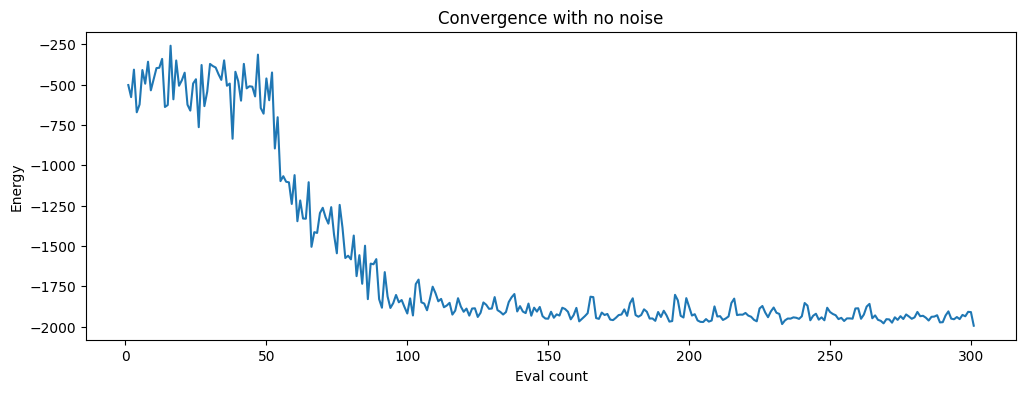

In [ ]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In [ ]:
result_vqe.eigenvalue.real

-1994.634765625